# Option pricing with Hull White Model

## 對 Hull White Model 模擬 Short Rate
### Code refer to : [Hull-White-simulation-quantlib-python](http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html)

In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [2]:
# variables for H-W model
sigma = float(input("Input the market volatility:"))  #市場波動度
a = float(input("Input the constant number in Hull White model: "))  #HW模型常數a
timestep = int(input("Input the total intervals of whole time: "))  #過程中共有幾個間格(月)
length = int(input("Input the total time takes in years: "))  #過程總時間
forward_rate = float(input("Input the forward rate form 0 to t: "))  #遠期利率
day_count = ql.Thirty360()  #30/360計算日方式
todays_date = ql.Date(12, 5, 2020)

Input the market volatility:0.1
Input the constant number in Hull White model: 0.1
Input the total intervals of whole time: 12
Input the total time takes in years: 1
Input the forward rate form 0 to t: 0.05


In [3]:
ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

In [4]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

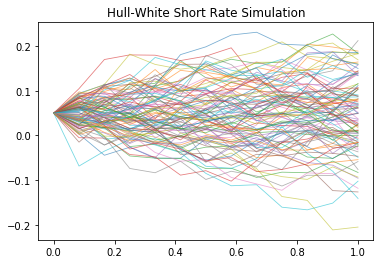

In [16]:
num_paths = 100
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

In [44]:
paths

array([[ 0.05      ,  0.06242905,  0.11252189, ...,  0.11190286,
         0.18021575,  0.14976213],
       [ 0.05      ,  0.09379065,  0.09832355, ...,  0.20413547,
         0.1977174 ,  0.18859003],
       [ 0.05      ,  0.03209971,  0.01664623, ...,  0.00211341,
        -0.00056316,  0.00048941],
       ...,
       [ 0.05      ,  0.02242862,  0.04158515, ...,  0.09305489,
         0.10439091,  0.14037568],
       [ 0.05      ,  0.00427316,  0.03234116, ...,  0.06141915,
         0.00300831, -0.0200814 ],
       [ 0.05      ,  0.05793482,  0.04948125, ...,  0.05665009,
         0.02633208, -0.00977611]])

## 將 Short Rate 代入 GBM，r 換成 r(t) 模擬股價

### Code refer to : [GBM by Teacher Tsai](https://colab.research.google.com/drive/1LL_m1UO_U2oHDMQhBDPjhUBANDpVhev7#scrollTo=nM_mFTMxlLWa)

In [21]:
# Variables for GBM
T = length
N = num_paths  # number of paths
dt = 1/12
#mu = 0.01*dt # Yield per unit of time(later be modify by short rate r(t))
#sigma = 0.1  # Given above in H-W model
S0 = 100  # current price of stock
np.random.seed(1)

In [37]:
def genBrownPath (T, mu, sigma, S0, dt):
    
    n = round(T/dt)
    t = time
    W = np.random.standard_normal(size = n)
    W = np.insert(W, 0, 0, axis=0)
    W = np.cumsum(W)*np.sqrt(dt) # == standard brownian motion
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) # == geometric brownian motion
    plt.plot(t, S)
    #print(mu)
    return S

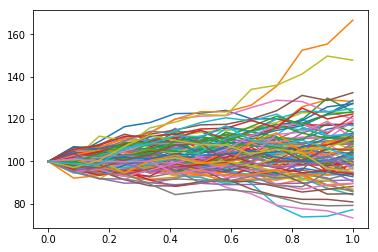

In [38]:
Paths = []
for i in range(N):
    Paths.append(genBrownPath(T, paths[i,:], sigma, S0, dt))
plt.show()

## 自訂選擇權履約價，計算每條 path 到期日之 payoff

In [40]:
Strike = 97  # strike price
#rate = 0.02  # risk-free rate can be determine by the end of every short rate path

In [41]:
payoff = []
for i in range(N):
    payoff.append(round(Paths[i][-1]-Strike,2))
print(payoff)

[20.49, 31.28, 12.65, 24.36, 6.55, 4.21, 15.12, -2.87, -10.39, 15.73, 31.86, 2.83, 12.41, -3.5, 20.15, 11.21, 3.58, 11.81, 1.12, -19.78, 7.05, 10.83, 7.16, 4.24, -6.44, 12.68, -23.65, 18.6, 26.1, -12.77, 13.35, 7.42, 26.36, 1.6, -11.07, 4.91, 23.12, 11.0, 16.15, -2.18, 30.3, 69.66, 6.14, 2.13, -5.72, 35.45, 22.0, -2.56, 8.56, 5.08, 2.82, -0.17, 16.86, 1.39, 14.19, -8.79, 7.36, 4.07, 1.92, 0.33, -4.15, 13.59, 10.02, 14.68, 11.51, -12.22, -0.73, -3.34, -10.07, 19.94, 30.31, 9.08, 8.11, 20.98, -2.4, -16.12, 14.03, -11.22, 50.8, 27.86, 16.32, -7.48, 14.03, -2.94, 1.21, 15.68, 22.35, -17.74, 13.39, 15.73, 7.33, 9.16, 26.38, 25.4, 5.77, 8.35, -7.29, 3.99, -1.72, 4.92]


## 計算 Call Price and Put Price

In [46]:
call_psum = put_psum = 0
for i in range(N):
    if payoff[i]>0:
        call_psum += payoff[i] * np.exp(-paths[i][-1]*length)   #用無風險利率折現
    else:
        put_psum += -payoff[i] * np.exp(-paths[i][-1]*length)

print("The call price is: %f, and the put price is: %f." \
      %(call_psum/N, put_psum/N))

The call price is: 9.681637, and the put price is: 2.178714.
